To me, what would have made sense would have been to requantify GTEx with PODER and then get a sense of how many of the newly discovered transcripts were tissue specific or found in only a few tissues. The statement we are after is that most of the ancestyr-specif transcripts discoverted are tissue-specif (or more tissue-specif than the annotated ones! and so, we anticipate that this bias extends to many more tissues and cell types and needs to be fixed. The other way to do this would be  to look at hte tissue specificity distribution of the annotated transcripts that have similar expression levels as the newly discovered ones, show that the majority are tissue specific (which they probably will be) and then state since they have similar expression levels, we anticipate that many more ancestry-specific transcripts will be discovered once we  sequence more cell types and tissues

In [31]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [32]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [33]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [34]:


f = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/gtex/quantification_gencode.tpm.txt'
# f = expand(proc_cfg(config['gtex']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

df = pd.read_csv(f, sep='\t')
df.head()
# df.columns = [d if d == 'transcript' else d.split('GTEx_v9_ONT_data_sequence_data_')[1].split('.')[0] for d in df.columns]
df.rename({'transcript':'tid'}, axis=1, inplace=True)
# # df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [35]:
# https://academic.oup.com/bib/article/18/2/205/2562739
min_cpm = 0.1
min_samples = 1

# set all genes w/ expression <1 CPM --> 0
df[df < min_cpm] = 0

# remove all genes that are not expressed in at least one tissue
# the text must be wrong here because how can we filter 
# after log normalization for CPM >=1?
print(len(df.index))
df = df.loc[(df>=min_cpm).sum(axis=1)>=min_samples]
print(len(df.index))

# log-transform data and add 1 pseudocount
df = np.log2(df+1)

149837
149711


In [36]:
# add sample information so I can groupby different tissues
df = df.transpose()
meta_file = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/snakemake/gtex_lr-kallisto/GTEx_v9_metadata_with_ancestry.txt'
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample_id', 'tissue']], how='left',
                  left_index=True, 
                  right_on='sample_id')

tissue_map = {'Brain - Frontal Cortex (BA9)': 'Brain',
              'Brain - Cerebellar Hemisphere': 'Brain',
              'Brain - Putamen (basal ganglia)': 'Brain',
              'Lung': 'Lung',
              'Heart - Left Ventricle': 'Heart',
              'Muscle - Skeletal': 'Muscle',
              'Brain - Anterior cingulate cortex (BA24)': 'Brain',
              'Heart - Atrial Appendage': 'Heart',
              'Brain - Caudate (basal ganglia)': 'Brain',
              'Adipose - Subcutaneous': 'Adipose', 
              'Cells - Cultured fibroblasts': 'Fibroblasts', 
              'Liver': 'Liver',
              'Breast - Mammary Tissue': 'Breast', 
              'Pancreas': 'Pancrease', 
              'K562': 'Lymphblasts'}
df['sample'] = df.tissue.map(tissue_map)

df.drop(['sample_id', 'tissue'], axis=1, inplace=True)

In [37]:
# compute the mean value per tissue
df = df.groupby('sample').mean()
df = df.transpose()

In [38]:
tau_df = compute_tau(df)

Found 10 samples


In [39]:
tau_df.index.name = 'tid'

In [40]:
tau_df.to_csv(f'241108_gtex_flair_mean_{min_cpm}_tau.tsv', sep='\t')

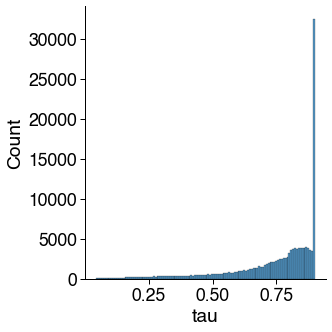

In [41]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

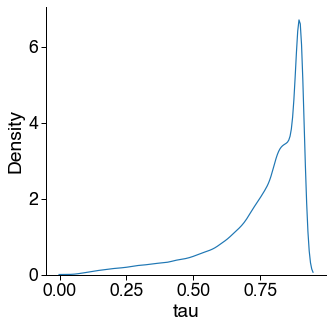

In [42]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='kde')

In [43]:
tau_df['high_tau'] = tau_df.tau>=.8
tau_df.reset_index().groupby('high_tau').count()

sample,tid,tau
high_tau,,
False,70441,70441
True,79270,79270
